In [ ]:
!pip install pandas plotly
##Import các thư viện và mount Google Drive:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
from scipy.optimize import minimize
from google.colab import drive, files
import matplotlib.pyplot as plt


drive.mount('/content/gdrive', force_remount=True)
path = "gdrive/My Drive/port/"

Mounted at /content/gdrive


In [ ]:
file_path = path + 'port.xlsx'
prices = pd.read_excel(file_path, sheet_name='Prices', index_col='Date', parse_dates=True)
market_caps = pd.read_excel(file_path, sheet_name='MarketCap')
parameters = pd.read_excel(file_path, sheet_name='Parameters')

<ipython-input-83-317ef544ff7f>:2: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
tickers = ['REE', 'HAH', 'ANV', 'PNJ']
filtered_prices = prices[tickers]

# Directly print the result since 'print_result' is not defined
print("Filtered Prices:")
print(filtered_prices.head())

Filtered Prices:
                REE      HAH      ANV      PNJ
Date                                          
2024-07-19  70300.0  43000.0  36000.0  95700.0
2024-07-18  72000.0  43950.0  35500.0  96000.0
2024-07-17  72200.0  42500.0  34550.0  95900.0
2024-07-16  73900.0  44350.0  34800.0  97100.0
2024-07-15  72000.0  45150.0  35500.0  97700.0


In [ ]:
# Use the 'prices' DataFrame as 'stocks_df'
stocks_df = prices.copy()  # Create a copy to avoid modifying the original

# Check if 'Date' is in the columns. If not, assume it's the index and reset it
if 'Date' not in stocks_df.columns:
    stocks_df = stocks_df.reset_index()  # Resets the index, moving 'Date' to a column

# Normalize the stock prices
def normalize(df):
    return df / df.iloc[0]

# Normalize the prices (now that 'Date' is a column)
normalized_stocks_df = normalize(stocks_df.set_index('Date'))

# Create an interactive plot
def interactive_plot(df, title):
    fig = go.Figure()
    for column in df.columns:
        fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name=column))

    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Normalized Price',
        template='plotly_dark'
    )
    pio.show(fig)

# Plot the normalized prices
interactive_plot(normalized_stocks_df, 'Normalized Prices')

In [ ]:
# Use the filtered_prices DataFrame as 'data'
data = prices.copy()  # Create a copy to avoid modifying the original

# Đầu tiên, sắp xếp lại dữ liệu từ ngày cũ nhất đến mới nhất
data = data.sort_index(ascending=True)

# Tính toán lợi suất hàng ngày
data['VNINDEX_return'] = data['VNINDEX'].pct_change()  # Assuming 'VNINDEX' is a column in filtered_prices
data['REE_return'] = data['REE'].pct_change()
data['HAH_return'] = data['HAH'].pct_change()
data['ANV_return'] = data['ANV'].pct_change()
data['PNJ_return'] = data['PNJ'].pct_change()

# (Tùy chọn) Sắp xếp lại dữ liệu từ ngày mới nhất đến cũ nhất
data = data.sort_index(ascending=False)

# Hiển thị dữ liệu sau khi tính toán
print(data)

            VNINDEX           REE           HAH           ANV           PNJ  \
Date                                                                          
2024-07-19  1264.78  70300.000000  43000.000000  36000.000000  95700.000000   
2024-07-18  1274.44  72000.000000  43950.000000  35500.000000  96000.000000   
2024-07-17  1268.66  72200.000000  42500.000000  34550.000000  95900.000000   
2024-07-16  1281.18  73900.000000  44350.000000  34800.000000  97100.000000   
2024-07-15  1279.82  72000.000000  45150.000000  35500.000000  97700.000000   
...             ...           ...           ...           ...           ...   
2020-07-27   785.17  19984.317934   3948.505662  12938.222596  36296.772729   
2020-07-24   829.16  20488.654033   4241.868533  13893.393392  39013.805620   
2020-07-23   856.75  21182.116169   4479.730320  14718.313625  41103.830921   
2020-07-22   855.08  20394.091014   4340.977611  14761.730479  40825.160881   
2020-07-21   861.69  20583.217052   4103.115824  149

In [ ]:
# Bỏ hàng đầu tiên vì không có dữ liệu lợi suất
returns = data.dropna()

# Lợi suất trung bình hàng ngày và độ lệch chuẩn của các cổ phiếu
mean_returns = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return']].mean()
std_returns = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return']].std()

# In lợi suất trung bình hàng ngày
print("Lợi suất trung bình hàng ngày của các cổ phiếu:")
for stock, mean in mean_returns.items():
    print(f"{stock}: {mean:.4f}")

# In độ lệch chuẩn hàng ngày
print("\nĐộ lệch chuẩn hàng ngày của các cổ phiếu:")
for stock, std in std_returns.items():
    print(f"{stock}: {std:.4f}")

Lợi suất trung bình hàng ngày của các cổ phiếu:
REE_return: 0.0015
HAH_return: 0.0028
ANV_return: 0.0014
PNJ_return: 0.0010

Độ lệch chuẩn hàng ngày của các cổ phiếu:
REE_return: 0.0213
HAH_return: 0.0305
ANV_return: 0.0319
PNJ_return: 0.0190


In [ ]:
# Hệ số beta của từng cổ phiếu so với VNINDEX
beta_REE = np.cov(returns['REE_return'], returns['VNINDEX_return'])[0, 1] / np.var(returns['VNINDEX_return'])
beta_HAH = np.cov(returns['HAH_return'], returns['VNINDEX_return'])[0, 1] / np.var(returns['VNINDEX_return'])
beta_ANV = np.cov(returns['ANV_return'], returns['VNINDEX_return'])[0, 1] / np.var(returns['VNINDEX_return'])
beta_PNJ = np.cov(returns['PNJ_return'], returns['VNINDEX_return'])[0, 1] / np.var(returns['VNINDEX_return'])

# In hệ số beta của từng cổ phiếu
print("Hệ số beta của từng cổ phiếu so với VNINDEX:")
print(f"REE: {beta_REE:.4f}")
print(f"HAH: {beta_HAH:.4f}")
print(f"ANV: {beta_ANV:.4f}")
print(f"PNJ: {beta_PNJ:.4f}")

Hệ số beta của từng cổ phiếu so với VNINDEX:
REE: 0.9352
HAH: 1.1894
ANV: 1.3337
PNJ: 0.8651


In [ ]:

# Hệ số beta của từng cổ phiếu
betas = np.array([beta_REE, beta_HAH, beta_ANV, beta_PNJ])

risk_free_rate = parameters.loc[parameters['Parameter'] == 'RiskFreeRate', 'Value'].iloc[0]
risk_free_rate = float(str(risk_free_rate).replace(',', '.'))  # Chuyển đổi từ chuỗi có dấu phẩy sang float
print("Risk-Free Rate", risk_free_rate)

# Lợi suất phi rủi ro và lợi suất kỳ vọng của thị trường (giả định)
Rf = risk_free_rate / 252  # Giả định lãi suất phi rủi ro hàng ngày
Rm = returns['VNINDEX_return'].mean()  # Lợi suất trung bình hàng ngày của VNINDEX

# Lợi suất kỳ vọng của từng cổ phiếu dựa trên CAPM
expected_returns = Rf + betas * (Rm - Rf)

# Hàm mục tiêu: Lợi suất kỳ vọng của danh mục đầu tư
def portfolio_return(weights):
    return np.dot(weights, expected_returns)

# Hàm tính độ lệch chuẩn của danh mục đầu tư
def portfolio_std(weights):
    covariance_matrix = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return']].cov().values
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# Hàm để tối ưu hóa: tỷ số Sharpe của danh mục
def sharpe_ratio(weights):
    return - (portfolio_return(weights) - Rf) / portfolio_std(weights)

# Ràng buộc: tổng trọng số bằng 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Ràng buộc: các trọng số không âm
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

# Trọng số ban đầu
initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

# Tối ưu hóa danh mục đầu tư
result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Kết quả
optimal_weights = result.x
expected_return = portfolio_return(optimal_weights)
expected_std = portfolio_std(optimal_weights)
optimal_sharpe = -result.fun

# Hiển thị kết quả
print("Trọng số tối ưu của danh mục đầu tư:")
for asset, weight in zip(mean_returns.index, optimal_weights):
    print(f"{asset}: {weight:.4f}")

print(f"\nLợi suất kỳ vọng của danh mục đầu tư: {expected_return:.4f}")
print(f"Độ lệch chuẩn của danh mục đầu tư: {expected_std:.4f}")
print(f"Tỷ số Sharpe tối ưu: {optimal_sharpe:.4f}")


Risk-Free Rate 0.02
Trọng số tối ưu của danh mục đầu tư:
REE_return: 0.2938
HAH_return: 0.1415
ANV_return: 0.1549
PNJ_return: 0.4099

Lợi suất kỳ vọng của danh mục đầu tư: 0.0005
Độ lệch chuẩn của danh mục đầu tư: 0.0175
Tỷ số Sharpe tối ưu: 0.0221


In [ ]:
Rm

0.00046413500102689473

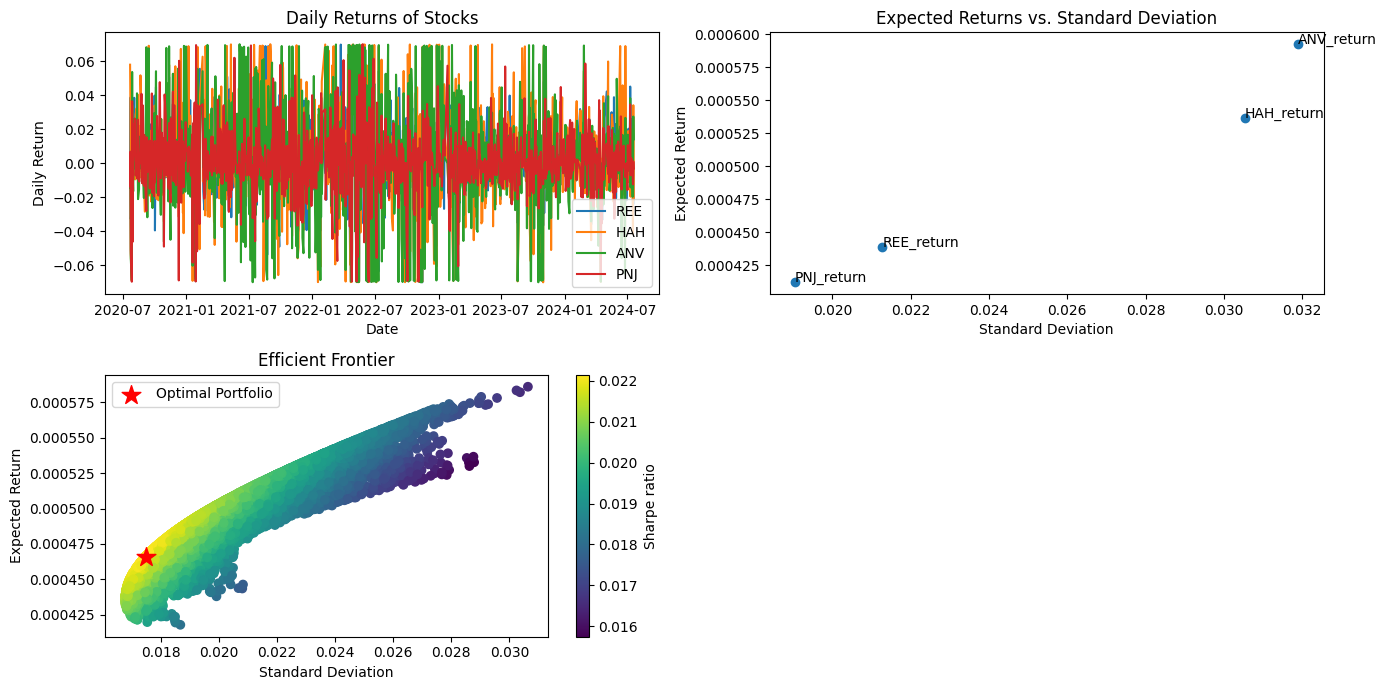

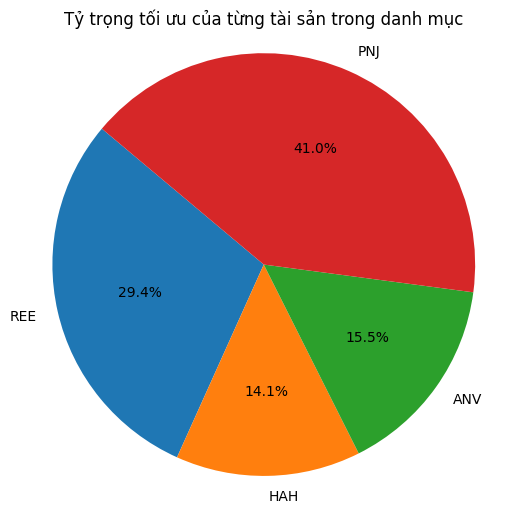

In [ ]:
# Plot daily returns of each stock
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.plot(returns.index, returns['REE_return'], label='REE')
plt.plot(returns.index, returns['HAH_return'], label='HAH')
plt.plot(returns.index, returns['ANV_return'], label='ANV')
plt.plot(returns.index, returns['PNJ_return'], label='PNJ')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns of Stocks')
plt.legend()

# Plot expected returns vs. standard deviation of the stocks
plt.subplot(2, 2, 2)
plt.scatter(std_returns, expected_returns)
for i, txt in enumerate(mean_returns.index):
    plt.annotate(txt, (std_returns[i], expected_returns[i]))
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Expected Returns vs. Standard Deviation')

# Plot Efficient Frontier
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Generate random portfolios
num_portfolios = 50000
results = np.zeros((3, num_portfolios))
cov_matrix = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return']].cov().values

for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    port_return = np.dot(weights, expected_returns)
    port_std = np.sqrt(portfolio_variance(weights, cov_matrix))
    results[0,i] = port_std
    results[1,i] = port_return
    results[2,i] = (port_return - Rf) / port_std

plt.subplot(2, 2, 3)
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

# Highlight optimal portfolio
plt.scatter(expected_std, expected_return, marker='*', color='r', s=200, label='Optimal Portfolio')
plt.legend()

plt.tight_layout()
plt.show()

# Biểu đồ tròn
asset_labels = ['REE', 'HAH', 'ANV', 'PNJ']
plt.figure(figsize=(6, 6))
plt.pie(optimal_weights, labels=asset_labels, autopct='%1.1f%%', startangle=140)
plt.title('Tỷ trọng tối ưu của từng tài sản trong danh mục')
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()


In [ ]:
# Giả định lãi suất trái phiếu là cố định và hệ số beta của trái phiếu là 0
bond_yield = parameters[parameters['Parameter'] == 'BondRate']['Value'].values[0]
risk_free_rate = parameters[parameters['Parameter'] == 'RiskFreeRate']['Value'].values[0]
bond_beta = 0


In [ ]:
bond_yield

0.0653

In [ ]:
# Thêm trái phiếu vào danh mục đầu tư hiện có
tickers = ['REE', 'HAH', 'ANV', 'PNJ']
bond_ticker = 'BOND'
returns[bond_ticker] = bond_yield / 365

<ipython-input-94-cf245c33de41>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Lợi suất kỳ vọng và hệ số beta của từng tài sản
mean_returns = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return', bond_ticker]].mean()
cov_matrix = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return', bond_ticker]].cov()
betas = {
    'REE': beta_REE,
    'HAH': beta_HAH,
    'ANV': beta_ANV,
    'PNJ': beta_PNJ,
    bond_ticker: bond_beta
}


In [ ]:
mean_returns

REE_return    0.001456
HAH_return    0.002820
ANV_return    0.001387
PNJ_return    0.001021
BOND          0.000179
dtype: float64

In [ ]:
betas

{'REE': 0.9351764078234711,
 'HAH': 1.1893616644981233,
 'ANV': 1.333732586500737,
 'PNJ': 0.8651356511169774,
 'BOND': 0}

Risk-Free Rate 0.02
Trọng số tối ưu của danh mục đầu tư:
REE_return: 0.2026
HAH_return: 0.1237
ANV_return: 0.1197
PNJ_return: 0.3519
BOND: 0.2022

Lợi suất kỳ vọng của danh mục đầu tư: 0.0004
Độ lệch chuẩn của danh mục đầu tư: 0.0139
Tỷ số Sharpe tối ưu: 0.0236


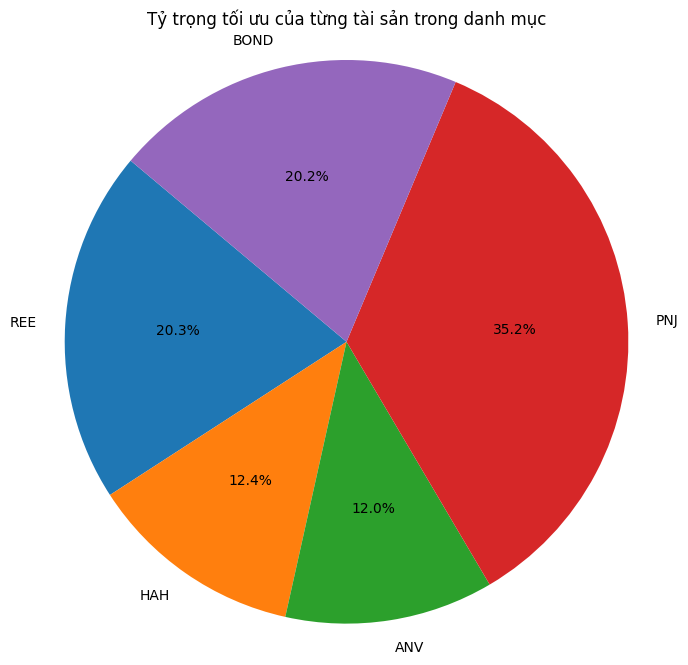

In [ ]:
# Hệ số beta của từng tài sản
betas = np.array([beta_REE, beta_HAH, beta_ANV, beta_PNJ, bond_beta])

risk_free_rate = parameters.loc[parameters['Parameter'] == 'RiskFreeRate', 'Value'].iloc[0]
risk_free_rate = float(str(risk_free_rate).replace(',', '.'))  # Chuyển đổi từ chuỗi có dấu phẩy sang float
print("Risk-Free Rate", risk_free_rate)

# Lợi suất phi rủi ro và lợi suất kỳ vọng của thị trường (giả định)
Rf = risk_free_rate / 365  # Giả định lãi suất phi rủi ro theo ngày
Rm = returns['VNINDEX_return'].mean()  # Lợi suất trung bình theo ngày của VNINDEX

# Lợi suất kỳ vọng của từng cổ phiếu dựa trên CAPM
expected_returns = Rf + betas * (Rm - Rf)

# Hàm mục tiêu: Lợi suất kỳ vọng của danh mục đầu tư
def portfolio_return(weights):
    return np.dot(weights, expected_returns)

# Hàm tính độ lệch chuẩn của danh mục đầu tư
def portfolio_std(weights):
    covariance_matrix = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return', 'BOND']].cov().values
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# Hàm để tối ưu hóa: tỷ số Sharpe của danh mục
def sharpe_ratio(weights):
    return - (portfolio_return(weights) - Rf) / portfolio_std(weights)

# Ràng buộc: tổng trọng số bằng 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Ràng buộc: các trọng số không âm
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

# Trọng số ban đầu
initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

# Tối ưu hóa danh mục đầu tư
result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Kết quả
optimal_weights = result.x
expected_return = portfolio_return(optimal_weights)
expected_std = portfolio_std(optimal_weights)
optimal_sharpe = -result.fun

# Hiển thị kết quả
print("Trọng số tối ưu của danh mục đầu tư:")
for asset, weight in zip(mean_returns.index, optimal_weights):
    print(f"{asset}: {weight:.4f}")

print(f"\nLợi suất kỳ vọng của danh mục đầu tư: {expected_return:.4f}")
print(f"Độ lệch chuẩn của danh mục đầu tư: {expected_std:.4f}")
print(f"Tỷ số Sharpe tối ưu: {optimal_sharpe:.4f}")

# Biểu đồ tròn
asset_labels = ['REE', 'HAH', 'ANV', 'PNJ', 'BOND']
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights, labels=asset_labels, autopct='%1.1f%%', startangle=140)
plt.title('Tỷ trọng tối ưu của từng tài sản trong danh mục')
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()


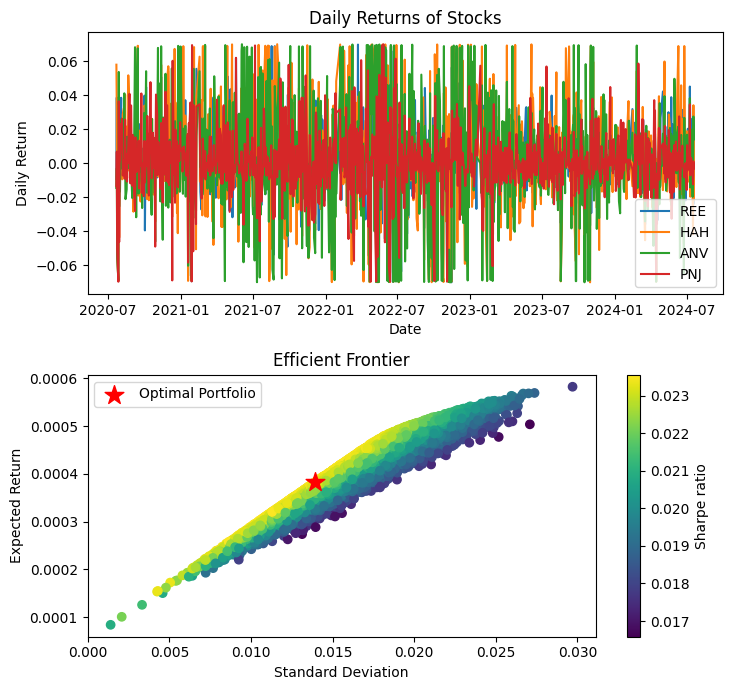

In [ ]:
# Plot daily returns of each stock
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.plot(returns.index, returns['REE_return'], label='REE')
plt.plot(returns.index, returns['HAH_return'], label='HAH')
plt.plot(returns.index, returns['ANV_return'], label='ANV')
plt.plot(returns.index, returns['PNJ_return'], label='PNJ')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns of Stocks')
plt.legend()



# Plot Efficient Frontier
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Generate random portfolios
num_portfolios = 50000
results = np.zeros((3, num_portfolios))
cov_matrix = returns[['REE_return', 'HAH_return', 'ANV_return', 'PNJ_return', 'BOND']].cov().values

for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    port_return = np.dot(weights, expected_returns)
    port_std = np.sqrt(portfolio_variance(weights, cov_matrix))
    results[0,i] = port_std
    results[1,i] = port_return
    results[2,i] = (port_return - Rf) / port_std

plt.subplot(2, 2, 3)
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

# Highlight optimal portfolio
plt.scatter(expected_std, expected_return, marker='*', color='r', s=200, label='Optimal Portfolio')
plt.legend()

plt.tight_layout()
plt.show()